# Primer design for open reading frame cloned in pYPKa

This notebook contains boilerplate code for the design of primers for an open reading frame to be cloned using the yeast pathway kit
and expressed in S. cerevisiae.

In [25]:
from pydna.amplify import pcr
from pydna.readers import read
from pydna.design import primer_design

from pydna.genbankrecord import GenbankRecord
from IPython.display import display_markdown

Paste open reading frame (orf) below in FASTA format. 

In [26]:
orf = read("""

>CTT1
ATGAACGTGTTCGGTAAAAAAGAAGAAAAGCAAGAAAAAGTTTACTCTCTACAAAACGGTTTTCCGTACTCTCATCACCCATACGCTTCTCAATACTCAAGACCAGACGGCCCTATCTTACTGCAAGACTTCCATCTGCTGGAAAATATCGCAAGTTTCGATAGAGAAAGAGTTCCGGAGCGTGTAGTCCATGCCAAAGGTGGTGGTTGTAGACTGGAGTTCGAACTAACAGATTCTTTGAGTGATATTACATACGCCGCTCCATACCAGAATGTGGGTTACAAATGTCCTGGTCTTGTTCGTTTTTCCACCGTTGGTGGTGAAAGTGGTACACCAGACACTGCAAGAGACCCAAGAGGTGTTTCTTTTAAATTCTATACCGAGTGGGGGAACCATGACTGGGTCTTCAACAATACTCCCGTCTTCTTCCTCAGAGACGCTATTAAGTTTCCCGTATTTATTCATTCGCAAAAGAGAGACCCTCAGTCTCATCTGAATCAGTTTCAGGACACTACCATATACTGGGATTATCTAACATTGAATCCGGAATCAATCCATCAAATAACTTACATGTTTGGTGATAGAGGTACTCCTGCTTCGTGGGCTAGTATGAACGCGTACTCTGGTCATTCCTTCATCATGGTCAACAAAGAAGGTAAGGACACATATGTGCAATTCCACGTCTTGTCGGATACTGGTTTTGAAACCTTGACTGGAGATAAGGCTGCTGAACTGTCAGGCTCCCACCCTGATTATAATCAGGCAAAGCTGTTCACTCAATTGCAAAATGGCGAAAAGCCAAAATTTAACTGTTATGTGCAAACAATGACACCCGAACAAGCAACTAAGTTCAGGTATTCGGTAAATGACCTAACGAAAATATGGCCACACAAGGAATTCCCTTTGAGAAAATTTGGTACCATCACCCTAACGGAGAATGTTGACAATTATTTCCAAGAAATTGAACAAGTTGCATTCAGTCCAACGAACACTTGTATCCCAGGTATTAAGCCTTCTAATGATTCCGTTCTACAAGCCAGACTTTTCTCCTATCCAGACACTCAACGTCATAGATTGGGAGCCAACTATCAGCAATTGCCCGTCAACAGACCAAGAAACTTGGGATGTCCATACTCCAAAGGTGATTCCCAATACACTGCCGAACAGTGTCCATTTAAAGCAGTGAACTTCCAAAGGGACGGCCCAATGAGTTACTACAATTTCGGTCCTGAGCCAAATTATATTTCCAGTTTACCAAATCAAACTCTGAAATTCAAAAATGAAGACAACGACGAAGTATCTGATAAGTTCAAAGGGATAGTTCTTGACGAAGTAACAGAAGTTTCTGTGAGAAAACAGGAACAAGACCAAATCAGAAACGAGCATATTGTTGATGCCAAAATTAATCAATATTACTACGTTTATGGTATTAGTCCACTAGACTTCGAACAGCCAAGAGCTCTATATGAAAAGGTATACAACGATGAACAGAAGAAATTATTCGTTCATAACGTTGTTTGCCACGCTTGTAAGATCAAAGATCCTAAAGTCAAAAAGAGAGTTACGCAATACTTTGGTTTGCTAAACGAAGATTTGGGTAAAGTCATTGCAGAAGGCTTGGGAGTTCCTTGGGAACCTGTTGACCTTGAAGGTTATGCCAAGACTTGGTCCATTGCAAGTGCCAATTAA

""")

In [27]:
display_markdown(f"# {orf.id}", raw=True)

# CTT1

In [28]:
orf.useguid()

'unRT3TWPEXorUhgOrGZRvwcsZwU'

In [29]:
assert orf.useguid() == 'unRT3TWPEXorUhgOrGZRvwcsZwU'

orf should be a linear Dseqrecord object.

In [30]:
assert orf.linear == True

The isorf method confirmes that the object sequence is an open reading frame with a start and a stop codon.

In [31]:
assert orf.isorf()

This notebook contain calls to BLAST and genbank. These can be slow, so joblib is used to cache the result.

In [32]:
import sys
from joblib import Memory
memory = Memory(location=f"{sys.path[0]}/joblib_memory_cachedir", verbose=0)

In [33]:
@memory.cache
def genbank_accession(s:str):
    
    from Bio.Blast import NCBIWWW
    from Bio.Blast import NCBIXML

    result_handle = NCBIWWW.qblast("blastn",
                                   "nt",
                                    s,
                                    hitlist_size=10,
                                    alignments = 1,
                                    expect=1e-8)

    blast_records = NCBIXML.read(result_handle)
    
    result_handle.close()

    results = []
    length = len(s)

    for alignment in blast_records.alignments:
        
        for hsp in alignment.hsps:
            
            if hsp.identities == length: # only **perfect** matches !
                
                results.append((alignment.accession, *sorted((hsp.sbjct_start, hsp.sbjct_end))))

    return results

In [34]:
hit, *rest_of_hits = genbank_accession(str(orf.seq))

In [35]:
item, start, stop = hit

In [36]:
orf = GenbankRecord(orf, item=item, start=start, stop=stop, strand=1)

In [37]:
orf

Gbank(CP046087 678143-679831)(-1689)

In [38]:
orf.express()

cds,len,cai,gc,sta,stp,n-end,CGA,CGG,CGC,CCG,CTC,GCG,rare
ATG...TAA,563.0,0.767,0.413,1.0,0.47,3 min,0,0,0,3,1,1,0.009


The express method gives tells us:

- The codon adaptation index (cai)
- Whether a preferred stop codon is used or not (stp) 
- That the first amino acid is stabilizing/destabilizing (n-end)


### Modifications

Since the first aminoacid is destabilizing, a stabilizing glycine will be added to the n-terminal.
Since this amino acid is small and uncharged, it is not likely to affect the enzyme.

Primers amplifying from the second to the second last codons are designed:

In [39]:
amplicon = primer_design(orf[3:])

A tail is added to the forward primer containing an effective 9 bp kozak sequence, a start codon and the most common codon for glycine.

In [40]:
fp = "tctgcaataATGGGT" + amplicon.forward_primer

A tail is added to the reverse primer containing the preferred stop codon.

In [41]:
rp = amplicon.reverse_primer

In [42]:
fp.id = f"{orf.name}f"
rp.id = f"{orf.name}r"

In [43]:
fp.description = rp.description = f"{item} {start} {stop}"

In [44]:
for p in (fp, rp):
    print(p.format("fasta"))

>CTT1f CP046087 678143 679831
tctgcaataATGGGTAACGTGTTCGGTAAAAAAG

>CTT1r CP046087 678143 679831
TTAATTGGCACTTGCAATG



We perform a PCR with the newly constructed primers:

In [45]:
product = pcr(fp, rp, orf)

In [46]:
product.figure()

               5AACGTGTTCGGTAAAAAAG...CATTGCAAGTGCCAATTAA3
                                      |||||||||||||||||||
                                     3GTAACGTTCACGGTTAATT5
5tctgcaataATGGGTAACGTGTTCGGTAAAAAAG3
                |||||||||||||||||||
               3TTGCACAAGCCATTTTTTC...GTAACGTTCACGGTTAATT5

In [47]:
product.program()

|95°C|95°C               |    |tmf:55.3
|____|_____          72°C|72°C|tmr:55.8
|3min|30s  \ 55.2°C _____|____|45s/kb
|    |      \______/ 1:16|5min|GC 41%
|    |       30s         |    |1701bp

In [48]:
product

Amplicon(1701)

In [49]:
from pydna.gel import gel
from pydna.ladders import GeneRuler_1kb

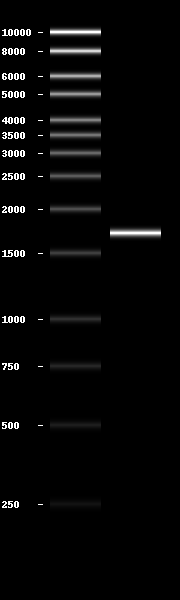

In [50]:
gel([GeneRuler_1kb,
     [product]])

In [51]:
print(product.seq)

tctgcaataATGGGTAACGTGTTCGGTAAAAAAGAAGAAAAGCAAGAAAAAGTTTACTCTCTACAAAACGGTTTTCCGTACTCTCATCACCCATACGCTTCTCAATACTCAAGACCAGACGGCCCTATCTTACTGCAAGACTTCCATCTGCTGGAAAATATCGCAAGTTTCGATAGAGAAAGAGTTCCGGAGCGTGTAGTCCATGCCAAAGGTGGTGGTTGTAGACTGGAGTTCGAACTAACAGATTCTTTGAGTGATATTACATACGCCGCTCCATACCAGAATGTGGGTTACAAATGTCCTGGTCTTGTTCGTTTTTCCACCGTTGGTGGTGAAAGTGGTACACCAGACACTGCAAGAGACCCAAGAGGTGTTTCTTTTAAATTCTATACCGAGTGGGGGAACCATGACTGGGTCTTCAACAATACTCCCGTCTTCTTCCTCAGAGACGCTATTAAGTTTCCCGTATTTATTCATTCGCAAAAGAGAGACCCTCAGTCTCATCTGAATCAGTTTCAGGACACTACCATATACTGGGATTATCTAACATTGAATCCGGAATCAATCCATCAAATAACTTACATGTTTGGTGATAGAGGTACTCCTGCTTCGTGGGCTAGTATGAACGCGTACTCTGGTCATTCCTTCATCATGGTCAACAAAGAAGGTAAGGACACATATGTGCAATTCCACGTCTTGTCGGATACTGGTTTTGAAACCTTGACTGGAGATAAGGCTGCTGAACTGTCAGGCTCCCACCCTGATTATAATCAGGCAAAGCTGTTCACTCAATTGCAAAATGGCGAAAAGCCAAAATTTAACTGTTATGTGCAAACAATGACACCCGAACAAGCAACTAAGTTCAGGTATTCGGTAAATGACCTAACGAAAATATGGCCACACAAGGAATTCCCTTTGAGAAAATTTGGTACCATCACCCTAACGGAGAATGTTGACAATTATTTCCAAGAAATTGAACAAGTTGCATTCAGTCCAACGA

In [52]:
product.orfs()

(Dseqrecord(-1692),
 Dseqrecord(-1119),
 Dseqrecord(-306),
 Dseqrecord(-225),
 Dseqrecord(-108))

In [53]:
new_orf, *rest = product.orfs()

In [54]:
new_orf

Dseqrecord(-1692)

The new protein is expected to be one amino acid longer.

In [55]:
assert len(orf.translate()) + 1 == len(new_orf.translate())

To avoid errors, we BLAST the new protein sequence against the refseq_protein database.

In [56]:
@memory.cache
def find_protein(s:str):
    from Bio.Blast import NCBIWWW
    from Bio.Blast import NCBIXML

    result_handle = NCBIWWW.qblast("blastp", 
                                   "nr", 
                                    s, 
                                    hitlist_size=10,
                                    alignments=1, 
                                    expect=1e-8)

    blast_records = NCBIXML.read(result_handle)
    
    result_handle.close()
    
    alignments = []
    
    for alignment in blast_records.alignments:
        alignments.append(alignment)
        
    return alignments

In [57]:
best_alignment, *rest_of_alignments = find_protein(str(new_orf.translate().seq))

In [58]:
print(best_alignment.accession)

EDV10159


In [59]:
from IPython.display import display, Markdown, display_markdown
display(Markdown(f'# [{best_alignment.accession}](https://www.ncbi.nlm.nih.gov/protein/{best_alignment.accession})'))

# [EDV10159](https://www.ncbi.nlm.nih.gov/protein/EDV10159)

In [60]:
best_alignment.hit_def

'catalase T [Saccharomyces cerevisiae RM11-1a] >gb|EGA74918.1| Ctt1p [Saccharomyces cerevisiae AWRI796] >gb|QHB08734.1| Ctt1 [Saccharomyces cerevisiae]'

In [61]:
hsps = []
for hsp in best_alignment.hsps:
    hsps.append(hsp)
best_hsp, *rest_of_hsps = hsps

In [62]:
print(best_hsp.match)

NVFGKKEEKQEKVYSLQNGFPYSHHPYASQYSRPDGPILLQDFHLLENIASFDRERVPERVVHAKGGGCRLEFELTDSLSDITYAAPYQNVGYKCPGLVRFSTVGGESGTPDTARDPRGVSFKFYTEWGNHDWVFNNTPVFFLRDAIKFPVFIHSQKRDPQSHLNQFQDTTIYWDYLTLNPESIHQITYMFGDRGTPASWASMNAYSGHSFIMVNKEGKDTYVQFHVLSDTGFETLTGDKAAELSGSHPDYNQAKLFTQLQNGEKPKFNCYVQTMTPEQATKFRYSVNDLTKIWPHKEFPLRKFGTITLTENVDNYFQEIEQVAFSPTNTCIPGIKPSNDSVLQARLFSYPDTQRHRLGANYQQLPVNRPRNLGCPYSKGDSQYTAEQCPFKAVNFQRDGPMSYYNFGPEPNYISSLPNQTLKFKNEDNDEVSDKFKGIVLDEVTEVSVRKQEQDQIRNEHIVDAKINQYYYVYGISPLDFEQPRALYEKVYNDEQKKLFVHNVVCHACKIKDPKVKKRVTQYFGLLNEDLGKVIAEGLGVPWEPVDLEGYAKTWSIASAN


In [63]:
best_hsp.match in orf.translate()

True

### Pairwise alignment

Aligning the two protein sequences confirms that 

In [64]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
alignments = pairwise2.align.globalxx(best_hsp.match, orf.translate().seq)

In [65]:
print(format_alignment(*alignments[0]))

-NVFGKKEEKQEKVYSLQNGFPYSHHPYASQYSRPDGPILLQDFHLLENIASFDRERVPERVVHAKGGGCRLEFELTDSLSDITYAAPYQNVGYKCPGLVRFSTVGGESGTPDTARDPRGVSFKFYTEWGNHDWVFNNTPVFFLRDAIKFPVFIHSQKRDPQSHLNQFQDTTIYWDYLTLNPESIHQITYMFGDRGTPASWASMNAYSGHSFIMVNKEGKDTYVQFHVLSDTGFETLTGDKAAELSGSHPDYNQAKLFTQLQNGEKPKFNCYVQTMTPEQATKFRYSVNDLTKIWPHKEFPLRKFGTITLTENVDNYFQEIEQVAFSPTNTCIPGIKPSNDSVLQARLFSYPDTQRHRLGANYQQLPVNRPRNLGCPYSKGDSQYTAEQCPFKAVNFQRDGPMSYYNFGPEPNYISSLPNQTLKFKNEDNDEVSDKFKGIVLDEVTEVSVRKQEQDQIRNEHIVDAKINQYYYVYGISPLDFEQPRALYEKVYNDEQKKLFVHNVVCHACKIKDPKVKKRVTQYFGLLNEDLGKVIAEGLGVPWEPVDLEGYAKTWSIASAN-
 |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [66]:
for p in (fp, rp):
    print(p.format("fasta"))

>CTT1f CP046087 678143 679831
tctgcaataATGGGTAACGTGTTCGGTAAAAAAG

>CTT1r CP046087 678143 679831
TTAATTGGCACTTGCAATG

